In [1]:
import os
from types import FunctionType
import numpy as np
import pandas as pd
import scipy.linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
# import scipy.linalg.hadamard as hadamard


In [12]:
def get_gt(n_traj=10,n_state=3,len=10):
    p_gt = np.random.rand(n_state,n_state)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        traj[k,0] = s + 1
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_state(s,p)
            traj[k,i] = s + 1
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_mdp_gt(n_traj=10,n_state=3,n_action=3,len=10):
    p_gt = np.random.rand(n_state,n_state*n_action)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len,2])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        a = np.random.randint(n_action)
        traj[k,0] = [s + 1, a]
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_mdp_state(s,a,p)
            traj[k,i] = [s + 1,a]
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_p_k(n_traj=3,n_state=3):
    p = np.zeros([n_traj,n_state,n_state])
    p_k = np.zeros([n_traj,n_state,n_state])    
    for k in range(n_traj):
        for i in range(n_state):
            for j in range(n_state):
                temp = np.random.rand()
                if temp > 0.5:
                    p_k[k,i,j] = 1
                else:
                    p_k[k,i,j] = 0
                if j == 0:
                    p[k,i,j] = p_k[k,i,j]
                else:
                    p[k,i,j] = p[k,i,j-1] + p_k[k,i,j]
            p[k,i,:] = p[k,i,:] / p[k,i,n_state-1] 
        p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T
        p_k[k] = np.where(np.isnan(p_k[k]), 0, p_k[k])
        # print("p_gt",p_gt[k])
    return  p_k

def get_next_state(i,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        if prob < p[i,j]:
            return j
    return j

def get_next_mdp_state(i,a,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        print((j-1)*3+a-1)
        if prob < p[i,(j-1)*3+a-1]:
            return j
    return j

def get_p_bar(traj, n_state):
    # total = (len(traj[0])-1)
    p_bar = np.zeros([n_state,n_state])
    # print("traj[0]",len(traj))
    # print("traj[1]",len(traj[1]))
    for k in range(len(traj)):
        for i in range(len(traj[1])-1):
            p_bar[int(traj[k,i])-1,int(traj[k,i+1])-1] += 1
    p_bar = (p_bar.T/p_bar.sum(axis=1)).T
    p_bar = np.where(np.isnan(p_bar), 0, p_bar)
    return p_bar

def get_alpha(p_bar,p_k):
    n = len(p_k)
    # print("n",n)
    x0 = np.array([1/n]*n)
    # print("x0",x0)
    res = least_squares(fun, x0, bounds=(0, 1),args=(p_bar, p_k), verbose=1)
    alpha = res.x/sum(res.x)
    return alpha

def model(x, p_k):
    sum = 0
    for i in range(len(x)):
        sum += p_k[i]*x[i]
    return sum

def fun(x,p_bar,p_k):
    return sum((model(x, p_k) - p_bar)**2)

def get_p_hat(alpha,p_k):
    sum = 0
    for i in range(len(alpha)):
        sum += p_k[i]*alpha[i]
    return sum

def get_error(p_hat,Frobenius_gt):
    delta = p_hat - p_gt
#     print("delta",delta)
    Frobenius_delta = np.linalg.norm(delta)
    
#     print("Frobenius_gt",Frobenius_gt)
    error = Frobenius_delta/Frobenius_gt
    
    return error


In [18]:
# num of states
n = 10

traj, p_gt = get_gt(n_traj=1000,n_state=n,len=3000)
print("p_gt",p_gt)
Frobenius_gt = np.linalg.norm(p_gt)
print("Frobenius_gt",Frobenius_gt)
p_bar = get_p_bar(traj, n_state=n) 

p_gt [[0.12008548 0.16320237 0.04917028 0.08288324 0.00825849 0.11145572
  0.10683663 0.15857619 0.04852511 0.1510065 ]
 [0.07369166 0.06765162 0.04602716 0.13554432 0.16243104 0.16115488
  0.05199401 0.09259571 0.0771588  0.1317508 ]
 [0.17745117 0.03881868 0.07169188 0.06287284 0.1702025  0.06431022
  0.12626201 0.04348679 0.11129412 0.13360979]
 [0.08862195 0.10293628 0.00260218 0.0278536  0.20898507 0.166793
  0.11094694 0.13115507 0.02577881 0.1343271 ]
 [0.17658011 0.06808855 0.02802018 0.08089015 0.14379969 0.07965023
  0.11081536 0.12014745 0.00130118 0.1907071 ]
 [0.0578665  0.0310856  0.18554654 0.02025391 0.23595245 0.05616358
  0.09108936 0.0800743  0.10160827 0.14035948]
 [0.30207428 0.11759062 0.03403608 0.00255722 0.00506327 0.04743358
  0.32494263 0.07858529 0.05313657 0.03458046]
 [0.1325708  0.16048727 0.10146831 0.05184703 0.03270962 0.05195314
  0.15082518 0.0422703  0.19076641 0.08510195]
 [0.18868763 0.18112278 0.01428634 0.12915697 0.12879805 0.06517798
  0.11492

`ftol` termination condition is satisfied.
Function evaluations 113, initial cost 1.8761e-02, final cost 1.3116e-02, first-order optimality 8.04e-07.
error 0.5858943279514693


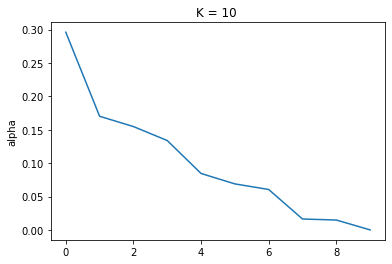

C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:72: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 415, initial cost 1.1448e-02, final cost 4.5424e-03, first-order optimality 1.50e-07.
error 0.4503410319018267


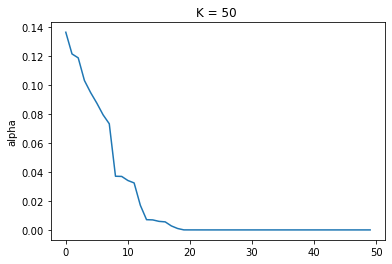

`ftol` termination condition is satisfied.
Function evaluations 378, initial cost 1.0741e-02, final cost 3.7729e-03, first-order optimality 1.32e-07.
error 0.4302959529086235


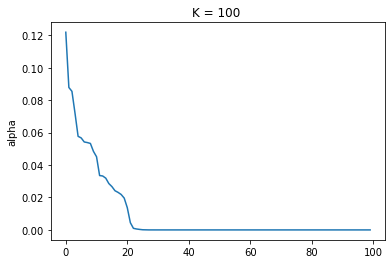

C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:72: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 511, initial cost 9.8428e-03, final cost 3.1493e-03, first-order optimality 5.73e-08.
error 0.41854237676386286


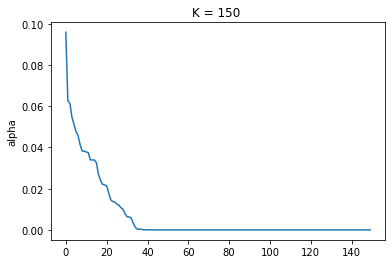

C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:72: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 552, initial cost 1.0759e-02, final cost 2.9784e-03, first-order optimality 9.45e-08.
error 0.4136360790916021


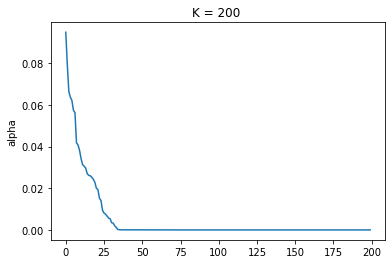

C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:72: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 859, initial cost 1.1107e-02, final cost 2.0211e-03, first-order optimality 4.55e-08.
error 0.37479433487866354


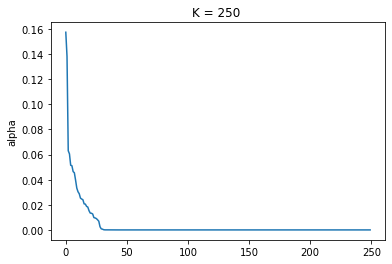

C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:72: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_26264/2565222776.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`ftol` termination condition is satisfied.
Function evaluations 910, initial cost 1.1685e-02, final cost 2.4018e-03, first-order optimality 6.91e-08.
error 0.3855847754268328


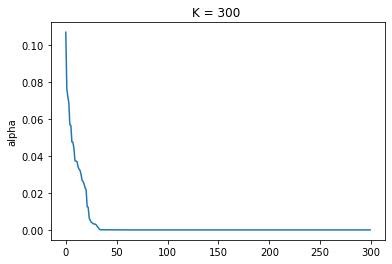

[0.5858943279514693, 0.4503410319018267, 0.4302959529086235, 0.41854237676386286, 0.4136360790916021, 0.37479433487866354, 0.3855847754268328]


In [19]:
# k_list = np.linspace(50, 200, 5, dtype=int,endpoint=True)
k_list = [10,50,100,150,200,250,300]
error_list = []
for k in k_list:
    p_k = get_p_k(n_traj=k,n_state=n)
    alpha = get_alpha(p_bar,p_k)
    p_hat = get_p_hat(alpha,p_k)
    error = get_error(p_hat,Frobenius_gt)
    print("error",error)
    error_list.append(error)
    
    sorted_alpha = np.sort(alpha)[::-1]
    plt.plot(sorted_alpha)
    plt.ylabel("alpha")
    plt.title("K = %i " % k)
    plt.show()
    
print(error_list)


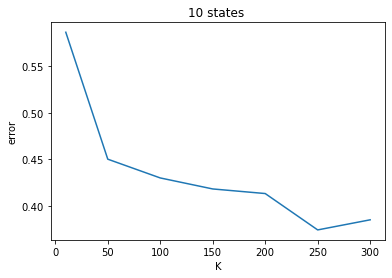

In [20]:
plt.plot(k_list,error_list)
plt.xlabel("K")
plt.ylabel("error")
plt.title("%i states " % n)
plt.show()

In [6]:
p_k = get_p_k(n_traj=800,n_state=n)
alpha = get_alpha(p_bar,p_k)
p_hat = get_p_hat(alpha,p_k)
error = get_error(p_hat,Frobenius_gt)
print("error",error)

C:\Users\Liuce\AppData\Local\Temp/ipykernel_16916/1997243371.py:44: RuntimeWarning: invalid value encountered in true_divide
  p[k,i,:] = p[k,i,:] / p[k,i,n_state-1]
C:\Users\Liuce\AppData\Local\Temp/ipykernel_16916/1997243371.py:45: RuntimeWarning: invalid value encountered in true_divide
  p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T


`gtol` termination condition is satisfied.
Function evaluations 274, initial cost 2.4545e-02, final cost 2.0889e-08, first-order optimality 9.87e-09.
error 0.0718683714543282
